<a href="https://colab.research.google.com/github/vinodthadi29/CODSOFT/blob/main/Movie_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install pandas numpy scikit-learn matplotlib seaborn nltk transformers

In [ ]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
# Instead of 'from sklearn.preprocessing import MultilabelBinarizer',
# use the following import statement to accommodate version changes
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import torch
from transformers import BertTokenizer, BertModel
import pickle
import warnings

In [ ]:
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [ ]:
# Download nltk resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Preprocessing helper functions
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    """Clean and preprocess a given text."""
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())  # Remove non-alphabetic characters
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

In [ ]:
# Load the data
train_data = pd.read_csv('/content/train_data.txt.zip', sep=':::', names=["Movie_name", "Gener", "Description"])
print("\nTraining Data Sample:")
print(train_data.head())


Training Data Sample:
                           Movie_name       Gener  \
1       Oscar et la dame rose (2009)       drama    
2                       Cupid (1997)    thriller    
3   Young, Wild and Wonderful (1980)       adult    
4              The Secret Sin (1915)       drama    
5             The Unrecovered (2007)       drama    

                                         Description  
1   Listening in to a conversation between his do...  
2   A brother and sister with a past incestuous r...  
3   As the bus empties the students for their fie...  
4   To help their unemployed father make ends mee...  
5   The film's title refers not only to the un-re...  


In [ ]:
train_data.describe()

,Movie_name,Gener,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Movie_name   54214 non-null  object
 1   Gener        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [ ]:
test_data = pd.read_csv('/content/test_data.txt.zip', sep='\t', header=None, names=['plot_summary'])
print("\nTest Data Sample:")
print(test_data.head())


Test Data Sample:
                                        plot_summary
0  1 ::: Edgar's Lunch (1998) ::: L.R. Brane love...
1  2 ::: La guerra de papá (1977) ::: Spain, Marc...
2  3 ::: Off the Beaten Track (2010) ::: One year...
3  4 ::: Meu Amigo Hindu (2015) ::: His father ha...
4  5 ::: Er nu zhai (1955) ::: Before he was know...


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   plot_summary  54200 non-null  object
dtypes: object(1)
memory usage: 423.6+ KB


In [ ]:
test_solution = pd.read_csv('/content/test_data_solution.txt.zip', sep='\t', header=None, names=['plot_summary', 'genre'])
print("\nTest Data Solution Sample:")
print(test_solution.head())


Test Data Solution Sample:
                                        plot_summary  genre
0  1 ::: Edgar's Lunch (1998) ::: thriller ::: L....    NaN
1  2 ::: La guerra de papá (1977) ::: comedy ::: ...    NaN
2  3 ::: Off the Beaten Track (2010) ::: document...    NaN
3  4 ::: Meu Amigo Hindu (2015) ::: drama ::: His...    NaN
4  5 ::: Er nu zhai (1955) ::: drama ::: Before h...    NaN


In [ ]:
# Handle missing genres by marking them as empty lists
train_data['genre'] = train_data['Gener'].fillna('Unknown').apply(lambda x: [])
test_solution['genre'] = test_solution['genre'].fillna('Unknown').apply(lambda x: [])

In [ ]:
# Check for missing values
print("\nChecking for missing values in training data:")
print(train_data.isnull().sum())
print("\nChecking for missing values in test data:")
print(test_data.isnull().sum())


Checking for missing values in training data:
Movie_name     0
Gener          0
Description    0
genre          0
dtype: int64

Checking for missing values in test data:
plot_summary    0
dtype: int64


In [ ]:
# Rename the 'Description' column to 'plot_summary'
train_data = train_data.rename(columns={'Description': 'plot_summary'})

In [ ]:
# Check and remove duplicates based on 'plot_summary' only
print("\nChecking for duplicates in training data...")
print("Duplicates found:", train_data['plot_summary'].duplicated().sum())
train_data = train_data[~train_data['plot_summary'].duplicated()]


Checking for duplicates in training data...
Duplicates found: 128


In [ ]:
# Check dataset size after cleaning
print("\nDataset sizes after cleaning:")
print("Training data size:", train_data.shape)
print("Test data size:", test_data.shape)


Dataset sizes after cleaning:
Training data size: (54086, 4)
Test data size: (54200, 1)


In [ ]:
# Remove outliers based on plot summary lengths
# *** ADJUSTMENT: Filter test_solution to match the indices of test_data after removing outliers ***
train_data = train_data[(train_data['summary_length'] >= 50) & (train_data['summary_length'] <= 5000)]
test_data = test_data[(test_data['summary_length'] >= 50) & (test_data['summary_length'] <= 5000)]

# Filter test_solution DataFrame to align with the cleaned test_data
test_solution = test_solution[test_solution.index.isin(test_data.index)]

In [ ]:
# Check plot summary lengths before removing outliers and filtering
train_data['summary_length'] = train_data['plot_summary'].apply(len)
test_data['summary_length'] = test_data['plot_summary'].apply(len)

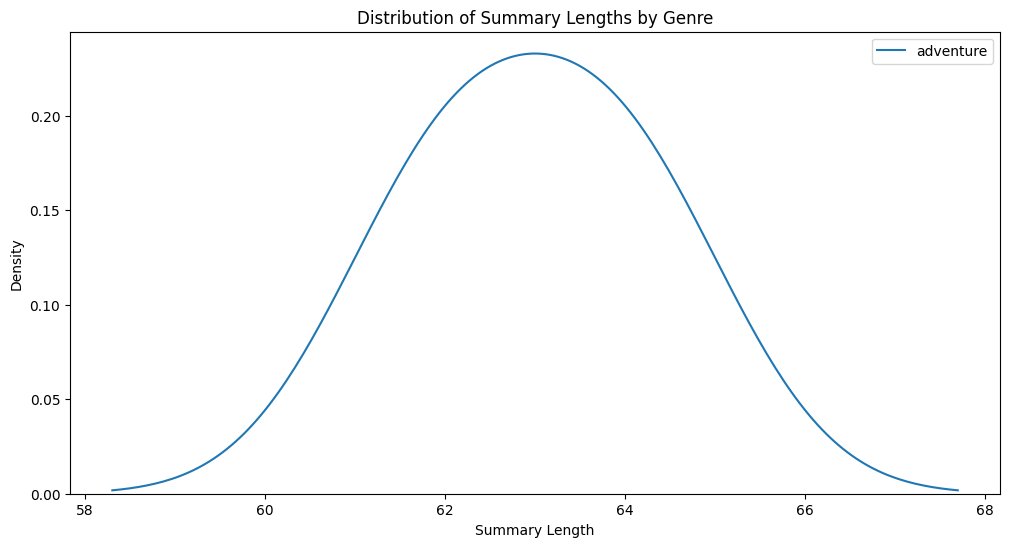

In [ ]:
# Visualize the distribution of summary lengths for each genre
plt.figure(figsize=(12, 6))
for genre in mlb.classes_:
    sns.kdeplot(train_data[train_data['genre'].apply(lambda x: genre in x)]['summary_length'], label=genre)
plt.title("Distribution of Summary Lengths by Genre")
plt.xlabel("Summary Length")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:
print("\nDataset sizes after removing outliers:")
print("Training data size:", train_data.shape)
print("Test data size:", test_data.shape)
print("Test Solution data size:", test_solution.shape) #Added this line for clarity


Dataset sizes after removing outliers:
Training data size: (54056, 5)
Test data size: (54185, 2)
Test Solution data size: (54185, 2)


In [ ]:
# Step 3: Preprocess the data
train_data['cleaned_plot'] = train_data['plot_summary'].apply(preprocess_text)
test_data['cleaned_plot'] = test_data['plot_summary'].apply(preprocess_text)

In [ ]:
# Display a few preprocessed plots for verification
print("\nPreprocessed Plot Summaries (Sample):")
print(train_data[['plot_summary', 'cleaned_plot']].head())


Preprocessed Plot Summaries (Sample):
                                        plot_summary  \
1   Listening in to a conversation between his do...   
2   A brother and sister with a past incestuous r...   
3   As the bus empties the students for their fie...   
4   To help their unemployed father make ends mee...   
5   The film's title refers not only to the un-re...   

                                        cleaned_plot  
1  listening conversation doctor parent yearold o...  
2  brother sister past incestuous relationship cu...  
3  bus empty student field trip museum natural hi...  
4  help unemployed father make end meet edith twi...  
5  film title refers unrecovered body ground zero...  


In [ ]:
# Ensure consistent genre representation across train and test data
def clean_genres(genres):
    genres = str(genres)  # Convert to string to handle NaN
    genres = genres.split(',')
    genres = [genre.strip() for genre in genres if genre.strip() != 'nan']  # Remove nan
    return genres

In [ ]:
# Split genres into lists, handling potential float values (NaN)
train_data['genre'] = train_data['Gener'].astype(str).apply(lambda x: x.split(',') if x != 'nan' else [])
test_solution['genre'] = test_solution['genre'].astype(str).apply(lambda x: x.split(',') if x != 'nan' else [])

In [ ]:
# Check class distribution
genre_counts = pd.Series([genre for genres in train_data['genre'] for genre in genres]).value_counts()
print("\nGenre Distribution:")
print(genre_counts)


Genre Distribution:
drama           13561
documentary     13074
comedy           7427
short            5058
horror           2201
thriller         1590
action           1313
western          1032
reality-tv        882
family            774
adventure         774
music             719
romance           669
sci-fi            647
adult             589
crime             503
animation         497
sport             430
talk-show         387
fantasy           321
mystery           316
musical           277
biography         265
history           243
game-show         194
news              181
war               132
Name: count, dtype: int64


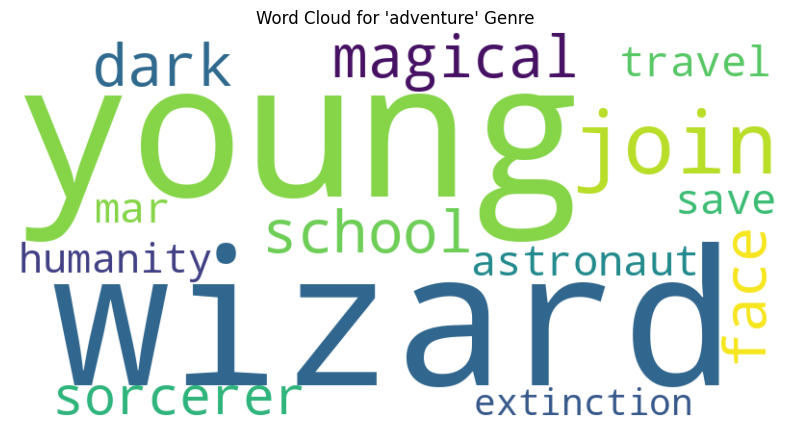

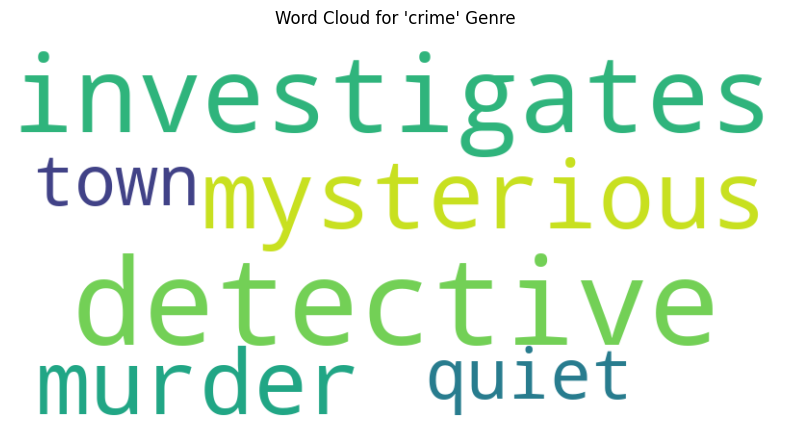

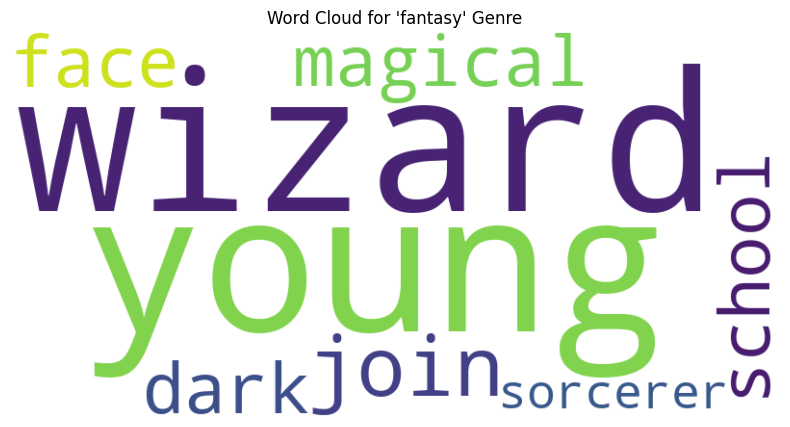

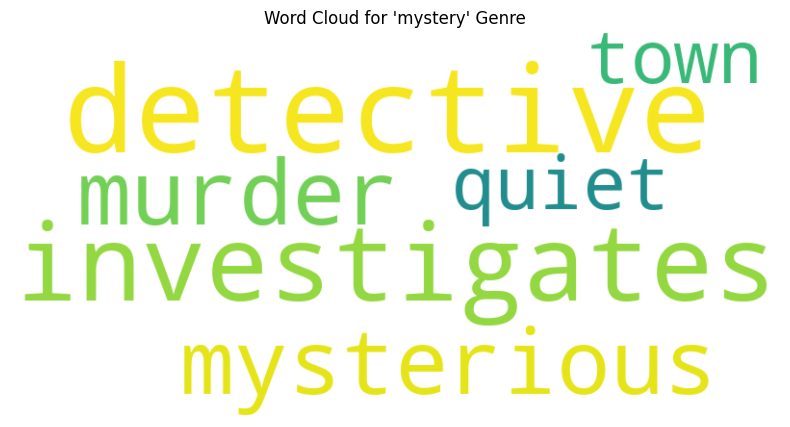

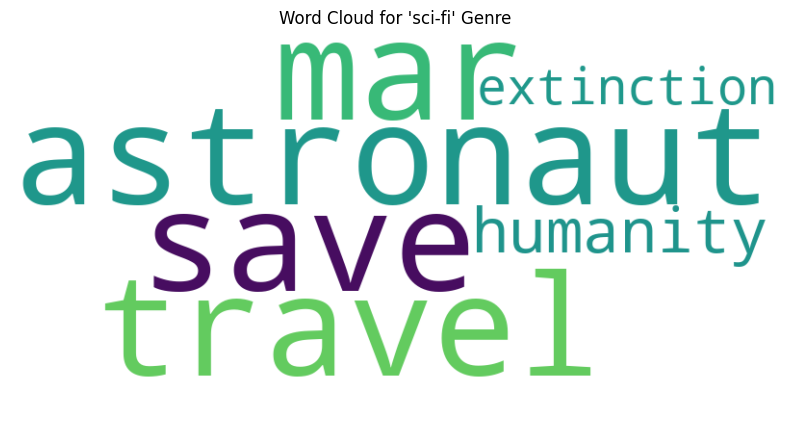

In [ ]:
# Create a word cloud for each genre to visualize the most frequent words
from wordcloud import WordCloud

for genre in mlb.classes_:
    text = " ".join(train_data[train_data['genre'].apply(lambda x: genre in x)]['cleaned_plot'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for '{genre}' Genre")
    plt.show()

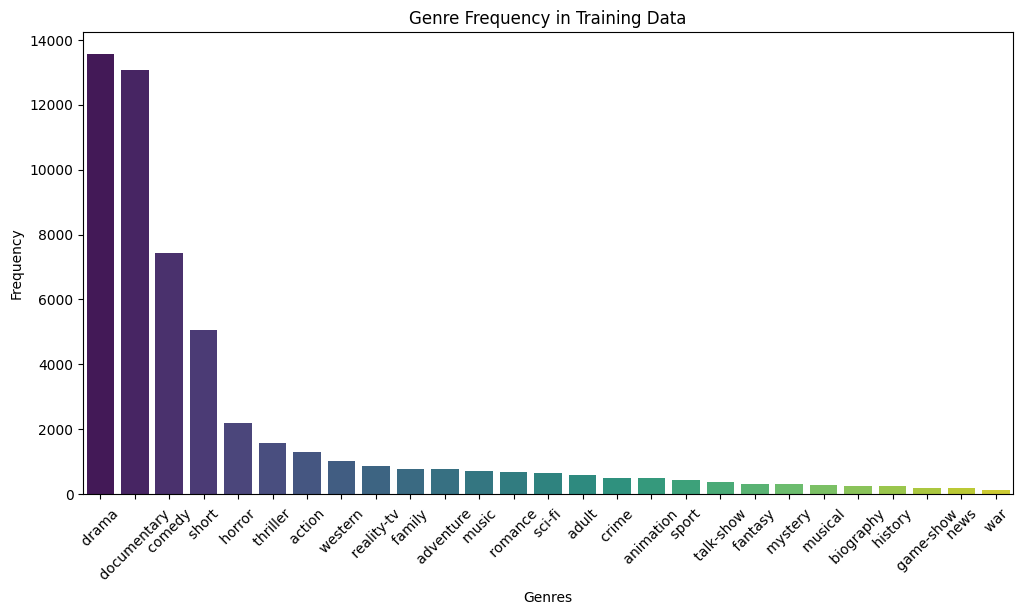

In [ ]:
# Plot genre frequency
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Genre Frequency in Training Data')
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.show()

In [ ]:

# Number of genres per movie
train_data['num_genres'] = train_data['genre'].apply(len)

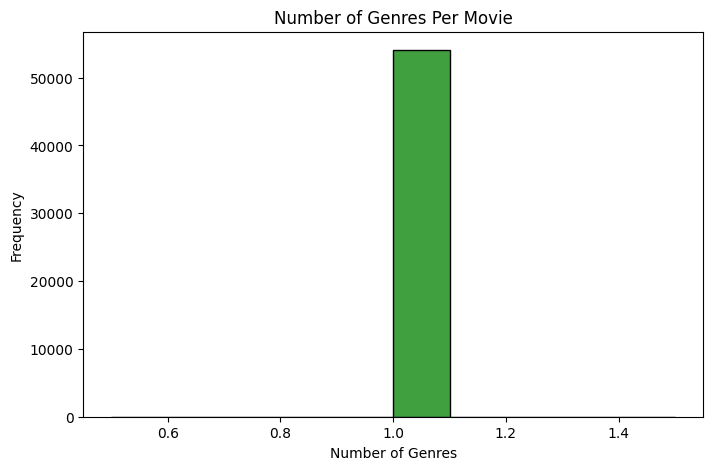

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(train_data['num_genres'], bins=10, kde=False, color='green')
plt.title('Number of Genres Per Movie')
plt.xlabel('Number of Genres')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Fit MultilabelBinarizer on combined genres from train and test
all_genres = [genre for genres in train_data['genre'] for genre in genres] + \
             [genre for genres in test_solution['genre'] for genre in genres]

In [ ]:
# Get unique genres and sort them to ensure consistent ordering
from sklearn.preprocessing import MultiLabelBinarizer # Import MultiLabelBinarizer here

unique_genres = sorted(list(set(all_genres)))
mlb = MultiLabelBinarizer(classes=unique_genres)  # using set to ensure unique classes
y_train = mlb.fit_transform(train_data['genre'])
y_test = mlb.transform(test_solution['genre'])

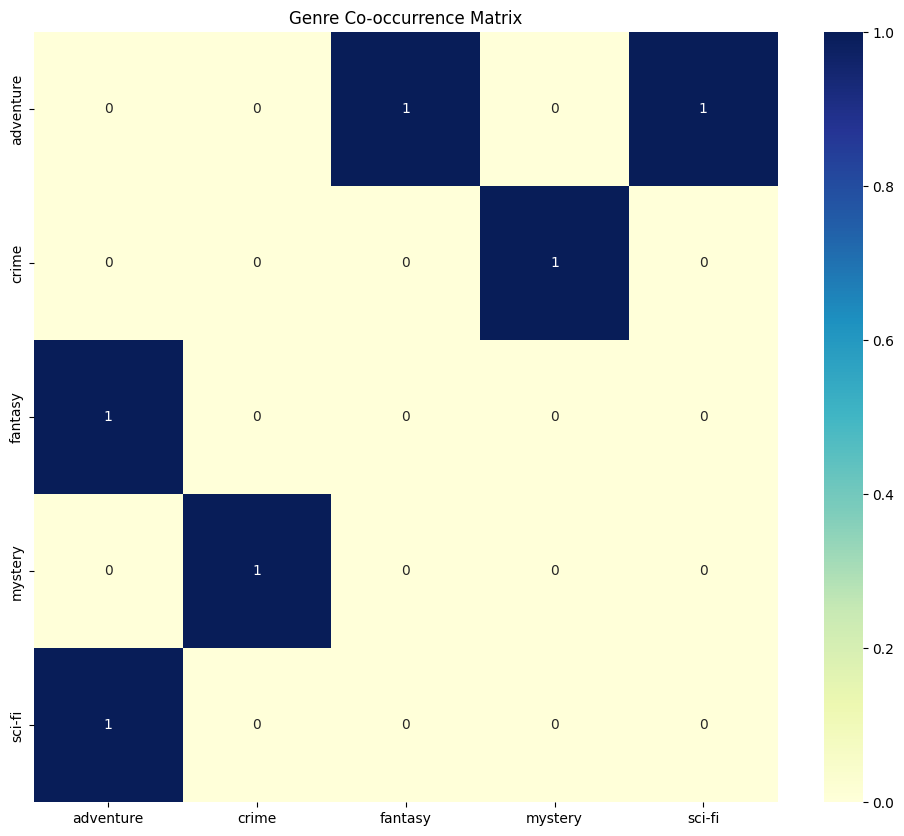

In [ ]:
# Create a co-occurrence matrix to visualize genre relationships
genre_cooccurrence = pd.DataFrame(np.zeros((len(mlb.classes_), len(mlb.classes_))),
                                   index=mlb.classes_,
                                   columns=mlb.classes_,
                                   dtype=int)  # Specify dtype as int

for genres in train_data['genre']:
    for genre1 in genres:
        for genre2 in genres:
            if genre1 != genre2:
                genre_cooccurrence.loc[genre1, genre2] += 1

# Plot the co-occurrence matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(genre_cooccurrence, annot=True, cmap="YlGnBu", fmt="d") # fmt="d" is now appropriate
plt.title("Genre Co-occurrence Matrix")
plt.show()

In [ ]:
print("\nEncoded Genre Sample:")
print(y_train[:5])
print("\nGenre Labels:")
print(mlb.classes_)


Encoded Genre Sample:
[[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

Genre Labels:
[' action ' ' adult ' ' adventure ' ' animation ' ' biography ' ' comedy '
 ' crime ' ' documentary ' ' drama ' ' family ' ' fantasy ' ' game-show '
 ' history ' ' horror ' ' music ' ' musical ' ' mystery ' ' news '
 ' reality-tv ' ' romance ' ' sci-fi ' ' short ' ' sport ' ' talk-show '
 ' thriller ' ' war ' ' western ' '[]']


In [ ]:
# Vectorize plot summaries with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['cleaned_plot'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['cleaned_plot'])

In [ ]:
# Hyperparameter tuning for Naive Bayes
param_grid_nb = {'estimator__alpha': [0.1, 0.5, 1]}
nb_model = OneVsRestClassifier(MultinomialNB())
grid_search_nb = GridSearchCV(nb_model, param_grid_nb, cv=3, scoring='f1_micro', verbose=1)
grid_search_nb.fit(X_train_tfidf, y_train)
best_nb_model = grid_search_nb.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [ ]:
# Define the bert_embeddings function
def bert_embeddings(text):
    """Generate BERT embeddings for a given text."""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

In [ ]:
# Initialize BERT tokenizer and model outside the function (if not already initialized)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = bert_model.to(device)


In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel
import numpy as np

# Initialize BERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased').eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def bert_embeddings_batch(texts, batch_size=16):
    """Generate BERT embeddings for a batch of texts."""
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=128)

        # Remove token_type_ids from the inputs dictionary
        if 'token_type_ids' in inputs:
            del inputs['token_type_ids']

        inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to GPU
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)
# Generate BERT embeddings for the subset
X_train_bert = bert_embeddings_batch(train_data_subset['cleaned_plot'].tolist(), batch_size=16)

# Save embeddings to disk
np.save('X_train_bert.npy', X_train_bert)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Ensure subset indices align with y_train's size
subset_size = 1000  # Use 1000 samples for faster computation
subset_indices = np.random.choice(len(y_train), subset_size, replace=False)  # Generate random indices

In [ ]:
# Select the subset
train_data_subset = train_data.iloc[subset_indices]
y_train_subset = y_train[subset_indices]

In [ ]:
subset_size = 500  # Reduce the subset size
subset_indices = np.random.choice(len(y_train), subset_size, replace=False)
train_data_subset = train_data.iloc[subset_indices]
y_train_subset = y_train[subset_indices]

In [ ]:
# Train MLP model on the subset
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, activation='relu')
mlp_model.fit(X_train_bert, y_train_subset)

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500)

In [ ]:
# Save the trained model
with open('mlp_model.pkl', 'wb') as f:
    pickle.dump(mlp_model, f)

print("MLP model trained and saved successfully.")

MLP model trained and saved successfully.


In [ ]:
# Naive Bayes - Using OneVsRestClassifier for multi-label classification
nb_model = OneVsRestClassifier(MultinomialNB())
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

In [ ]:
# Logistic Regression - Using OneVsRestClassifier for multi-label classification
lr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000, multi_class='ovr'))
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)


Dataset sizes after cleaning:
Training data size: (54056, 7)
Test data size: (54185, 3)


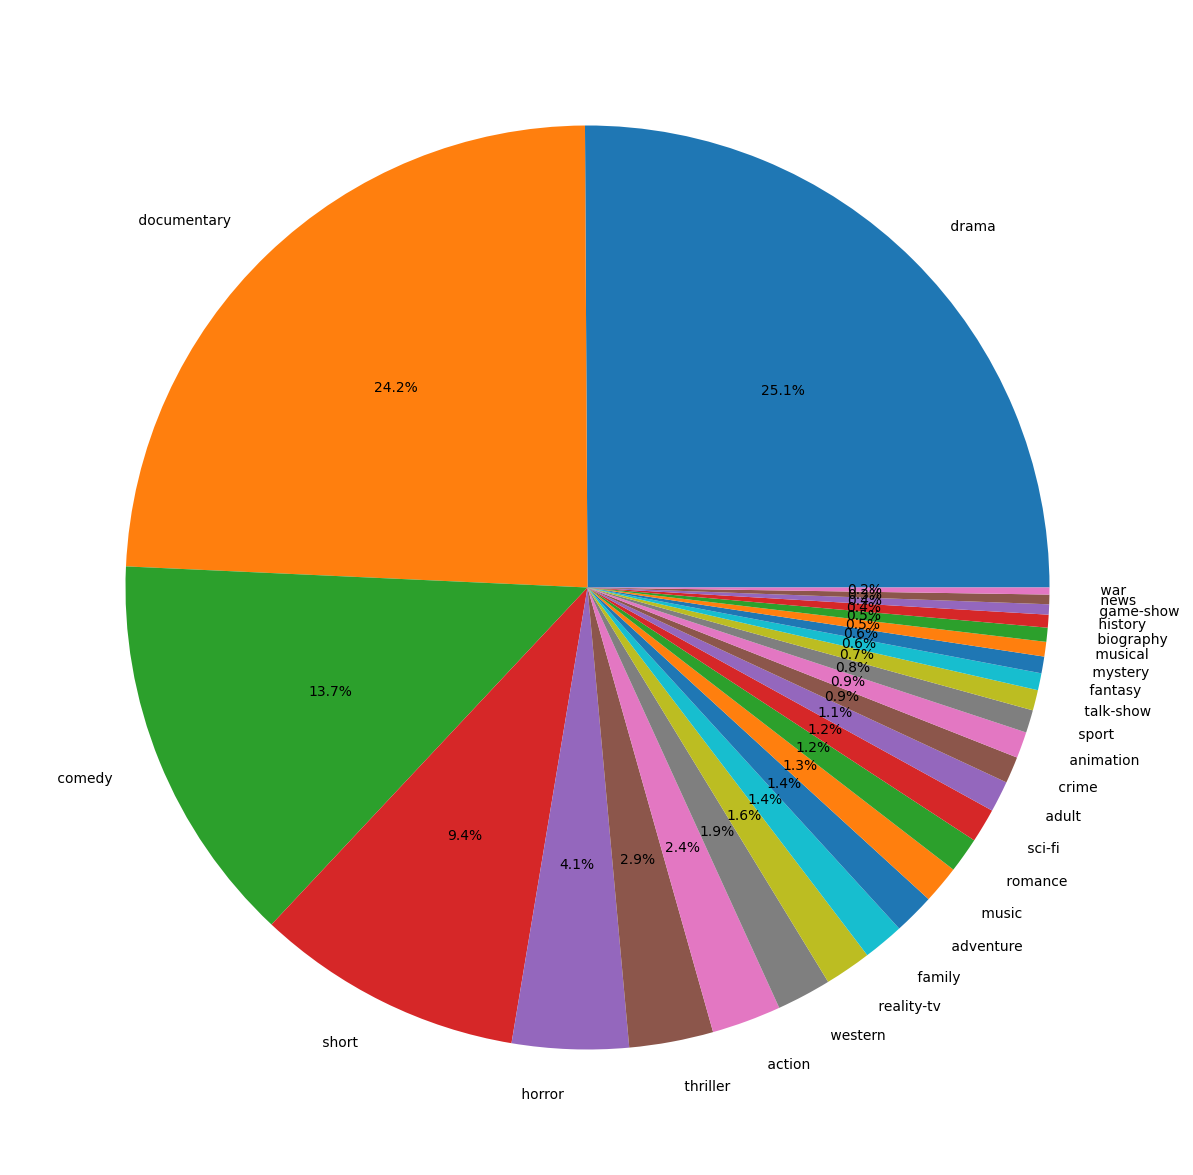

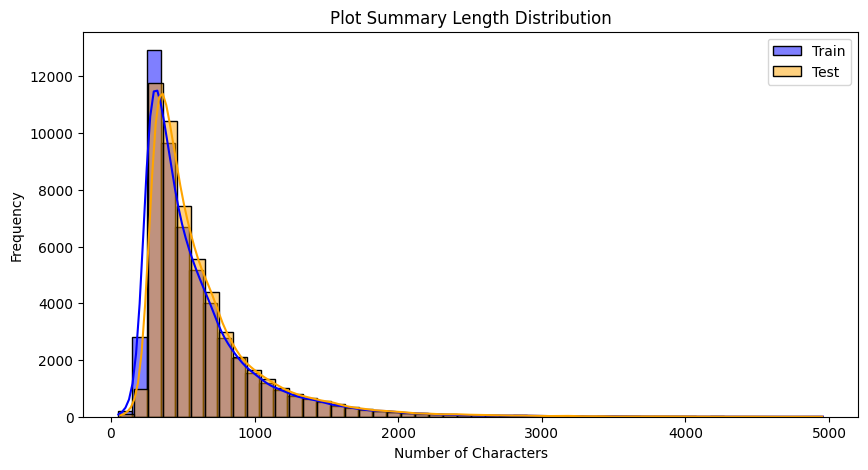


Dataset sizes after removing outliers:
Training data size: (54056, 7)
Test data size: (54185, 3)
Test Solution data size: (54185, 2)


In [ ]:
# Check dataset size after cleaning
print("\nDataset sizes after cleaning:")
print("Training data size:", train_data.shape)
print("Test data size:", test_data.shape)

# Plot the distribution of genres
plt.figure(figsize=(15,15))
plt.pie(train_data['Gener'].value_counts(), labels=train_data['Gener'].value_counts().index, autopct='%0.1f%%')
plt.show()

# Check plot summary lengths
train_data['summary_length'] = train_data['plot_summary'].apply(len)
test_data['summary_length'] = test_data['plot_summary'].apply(len)

# Plot the distribution of plot summary lengths
plt.figure(figsize=(10, 5))
sns.histplot(train_data['summary_length'], bins=50, kde=True, color='blue', label='Train')
sns.histplot(test_data['summary_length'], bins=50, kde=True, color='orange', label='Test')
plt.title('Plot Summary Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Remove outliers based on plot summary lengths
# *** ADJUSTMENT: Filter test_solution to match the indices of test_data after removing outliers ***
train_data = train_data[(train_data['summary_length'] >= 50) & (train_data['summary_length'] <= 5000)]
test_data = test_data[(test_data['summary_length'] >= 50) & (test_data['summary_length'] <= 5000)]

# Filter test_solution DataFrame to align with the cleaned test_data
test_solution = test_solution[test_solution.index.isin(test_data.index)]

# Update y_test after filtering test_solution in ipython-input-120-59e18764bd94
y_test = mlb.transform(test_solution['genre'].apply(lambda x: [g.strip() for g in x if g.strip()])) # Recalculate y_test

print("\nDataset sizes after removing outliers:")
print("Training data size:", train_data.shape)
print("Test data size:", test_data.shape)
print("Test Solution data size:", test_solution.shape) #Added this line for clarity

In [ ]:
# Evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate a model's performance."""
    y_pred = model.predict(X_test)
    # Convert y_pred to a dense NumPy array to ensure consistency
    y_pred = y_pred.toarray() if hasattr(y_pred, "toarray") else y_pred
    print(f"\n{model_name} Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=mlb.classes_))

evaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression")
evaluate_model(best_nb_model, X_test_tfidf, y_test, "Naive Bayes")


Logistic Regression Performance:
Accuracy: 0.0
Classification Report:
                precision    recall  f1-score   support

      action        0.00      0.00      0.00         0
       adult        0.00      0.00      0.00         0
   adventure        0.00      0.00      0.00         0
   animation        0.00      0.00      0.00         0
   biography        0.00      0.00      0.00         0
      comedy        0.00      0.00      0.00         0
       crime        0.00      0.00      0.00         0
 documentary        0.00      0.00      0.00         0
       drama        0.00      0.00      0.00         0
      family        0.00      0.00      0.00         0
     fantasy        0.00      0.00      0.00         0
   game-show        0.00      0.00      0.00         0
     history        0.00      0.00      0.00         0
      horror        0.00      0.00      0.00         0
       music        0.00      0.00      0.00         0
     musical        0.00      0.00      0.00   

In [ ]:
# Create a bar chart comparing the accuracy of different models
models = ['Logistic Regression', 'Naive Bayes']
accuracies = [accuracy_score(y_test, lr_model.predict(X_test_tfidf)),
              accuracy_score(y_test, nb_model.predict(X_test_tfidf))]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['skyblue', 'orange'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim([0, 1])  # Set y-axis limits for better visualization
plt.show()

In [ ]:
print("Number of classes in mlb:", len(mlb.classes_))
print("Classes in mlb:", mlb.classes_)

Number of classes in mlb: 28
Classes in mlb: [' action ' ' adult ' ' adventure ' ' animation ' ' biography ' ' comedy '
 ' crime ' ' documentary ' ' drama ' ' family ' ' fantasy ' ' game-show '
 ' history ' ' horror ' ' music ' ' musical ' ' mystery ' ' news '
 ' reality-tv ' ' romance ' ' sci-fi ' ' short ' ' sport ' ' talk-show '
 ' thriller ' ' war ' ' western ' '[]']


In [ ]:
if hasattr(lr_model, 'classes_'):
    print("Number of classes in Logistic Regression model:", len(lr_model.classes_))
if hasattr(nb_model, 'classes_'):
    print("Number of classes in Naive Bayes model:", len(nb_model.classes_))
if hasattr(mlp_model, 'classes_'):
    print("Number of classes in MLP model:", len(mlp_model.classes_))

Number of classes in Logistic Regression model: 28
Number of classes in Naive Bayes model: 28
Number of classes in MLP model: 28


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MultiLabelBinarizer
import pickle

# Example data (replace with your actual data)
train_data = pd.DataFrame({
    'plot_summary': [
        "A young wizard joins a magical school and faces a dark sorcerer.",
        "A detective investigates a mysterious murder in a quiet town.",
        "An astronaut travels to Mars to save humanity from extinction."
    ],
    'genre': [
        ["fantasy", "adventure"],
        ["mystery", "crime"],
        ["sci-fi", "adventure"]
    ]
})

# Preprocess the data
train_data['cleaned_plot'] = train_data['plot_summary'].apply(preprocess_text)

# Fit the MultilabelBinarizer
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_data['genre'])

# Vectorize the text data
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['cleaned_plot'])

# Train Logistic Regression model
lr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
lr_model.fit(X_train_tfidf, y_train)

# Train Naive Bayes model
nb_model = OneVsRestClassifier(MultinomialNB())
nb_model.fit(X_train_tfidf, y_train)

# Save the models and vectorizer
with open('lr_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

with open('nb_model.pkl', 'wb') as f:
    pickle.dump(nb_model, f)

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

with open('mlb_encoder.pkl', 'wb') as f:
    pickle.dump(mlb, f)

In [ ]:
def predict_genre(plot_summary, model_choice):
    """
    Predict genres for a given plot summary using the selected model.
    """
    try:
        # Preprocess the input text
        cleaned_plot = preprocess_text(plot_summary)
        print("Cleaned Plot:", cleaned_plot)  # Debug

        # Select the model based on user choice
        if model_choice == "Logistic Regression":
            # Transform the text into TF-IDF features
            features = tfidf_vectorizer.transform([cleaned_plot])
            model = lr_model
        elif model_choice == "Naive Bayes":
            # Transform the text into TF-IDF features
            features = tfidf_vectorizer.transform([cleaned_plot])
            model = nb_model
        elif model_choice == "MLP with BERT":
            # Generate BERT embeddings
            features = bert_embeddings(cleaned_plot)
            model = mlp_model

        # Predict genres
        if model_choice == "MLP with BERT":
            # Ensure the MLP model outputs predictions with the correct number of classes
            predicted = model.predict(features.reshape(1, -1))
        else:
            predicted = model.predict(features)

        print("Predicted Binary Labels:", predicted)  # Debug

        # Convert binary predictions to genre labels
        genres = mlb.inverse_transform(predicted)
        print("Predicted Genres:", genres)  # Debug

        # Format the output
        if len(genres[0]) > 0:
            return ", ".join(genres[0])
        else:
            return "No genres predicted."
    except Exception as e:
        return f"Error during prediction: {str(e)}"

In [ ]:
# Example: Train MLP model
from sklearn.neural_network import MLPClassifier

# Generate BERT embeddings for training data
X_train_bert = np.array([bert_embeddings(text) for text in train_data['cleaned_plot']])
# Reshape X_train_bert to 2D
X_train_bert = X_train_bert.reshape(X_train_bert.shape[0], -1)  # Reshape to (num_samples, num_features)

# Train MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, activation='relu')
mlp_model.fit(X_train_bert, y_train)

# Save the MLP model
with open('mlp_model.pkl', 'wb') as f:
    pickle.dump(mlp_model, f)

In [ ]:
try:
    with open('lr_model.pkl', 'rb') as f:
        lr_model = pickle.load(f)
    print("Logistic Regression model loaded successfully.")
except Exception as e:
    print(f"Error loading Logistic Regression model: {e}")

try:
    with open('nb_model.pkl', 'rb') as f:
        nb_model = pickle.load(f)
    print("Naive Bayes model loaded successfully.")
except Exception as e:
    print(f"Error loading Naive Bayes model: {e}")

try:
    with open('tfidf_vectorizer.pkl', 'rb') as f:
        tfidf_vectorizer = pickle.load(f)
    print("TF-IDF Vectorizer loaded successfully.")
except Exception as e:
    print(f"Error loading TF-IDF Vectorizer: {e}")

try:
    with open('mlb_encoder.pkl', 'rb') as f:
        mlb = pickle.load(f)
    print("MultilabelBinarizer loaded successfully.")
except Exception as e:
    print(f"Error loading MultilabelBinarizer: {e}")

try:
    with open('mlp_model.pkl', 'rb') as f:
        mlp_model = pickle.load(f)
    print("MLP model loaded successfully.")
except Exception as e:
    print(f"Error loading MLP model: {e}")

Logistic Regression model loaded successfully.
Naive Bayes model loaded successfully.
TF-IDF Vectorizer loaded successfully.
MultilabelBinarizer loaded successfully.
MLP model loaded successfully.


In [ ]:
try:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased').eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bert_model = bert_model.to(device)
    print("BERT model and tokenizer loaded successfully.")
except Exception as e:
    print(f"Error loading BERT model and tokenizer: {e}")

BERT model and tokenizer loaded successfully.


In [ ]:
new_plots = [
    "A young wizard joins a magical school and faces a dark sorcerer.",
    "A detective investigates a mysterious murder in a quiet town.",
    "An astronaut travels to Mars to save humanity from extinction."
]

In [ ]:
print("\nPredicted Genres for New Plots:")
for i, plot in enumerate(new_plots):
    genres = predict_genre(plot, "MLP with BERT")  # Pass "MLP with BERT" as the model choice
    print(f"Plot {i+1}: {plot}")
    print(f"Predicted Genres: {genres}")


Predicted Genres for New Plots:
Cleaned Plot: young wizard join magical school face dark sorcerer
Predicted Binary Labels: [[1 0 1 0 0]]
Predicted Genres: [('adventure', 'fantasy')]
Plot 1: A young wizard joins a magical school and faces a dark sorcerer.
Predicted Genres: adventure, fantasy
Cleaned Plot: detective investigates mysterious murder quiet town
Predicted Binary Labels: [[0 1 0 1 0]]
Predicted Genres: [('crime', 'mystery')]
Plot 2: A detective investigates a mysterious murder in a quiet town.
Predicted Genres: crime, mystery
Cleaned Plot: astronaut travel mar save humanity extinction
Predicted Binary Labels: [[1 0 0 0 1]]
Predicted Genres: [('adventure', 'sci-fi')]
Plot 3: An astronaut travels to Mars to save humanity from extinction.
Predicted Genres: adventure, sci-fi


In [ ]:
# Check if all required files are present
import os
required_files = ['nb_model.pkl', 'lr_model.pkl', 'tfidf_vectorizer.pkl', 'mlb_encoder.pkl']
missing_files = [file for file in required_files if not os.path.exists(file)]

if missing_files:
    print("Missing files:", missing_files)
else:
    print("All required files are present.")

print("\nModels and vectorizer saved.")

All required files are present.

Models and vectorizer saved.


In [ ]:
# Generate BERT embeddings for a single plot
cleaned_plot = preprocess_text("An astronaut travels to Mars to save humanity from extinction.")
print("Cleaned Plot:", cleaned_plot)

Cleaned Plot: astronaut travel mar save humanity extinction


In [ ]:
features = tfidf_vectorizer.transform([cleaned_plot])
print("TF-IDF Features Shape:", features.shape)
print("TF-IDF Features:", features.toarray())

TF-IDF Features Shape: (1, 20)
TF-IDF Features: [[0.40824829 0.         0.         0.40824829 0.         0.40824829
  0.         0.         0.         0.40824829 0.         0.
  0.         0.40824829 0.         0.         0.         0.40824829
  0.         0.        ]]


In [ ]:
# Generate BERT embeddings for the subset
# Assuming you have a variable 'cleaned_plot' containing the preprocessed text
embeddings = bert_embeddings_batch([cleaned_plot], batch_size=1)
print("BERT Embeddings Shape:", embeddings.shape)
print("BERT Embeddings:", embeddings)

BERT Embeddings Shape: (1, 768)
BERT Embeddings: [[ 1.49641484e-01  1.11005664e-01  1.22848749e-01  1.98702201e-01
   4.18980092e-01 -2.58568645e-01  1.52008653e-01  9.60539207e-02
   2.71281227e-02 -4.04946625e-01  6.42166883e-02 -5.04656583e-02
  -7.94860572e-02  2.87532508e-01 -1.72838598e-01  1.64121073e-02
  -1.86009422e-01  6.16709590e-02 -5.56144379e-02 -1.70626920e-02
   1.91818789e-01 -1.50949731e-01  1.39303178e-01  9.80933756e-02
   1.62841268e-02 -9.58957225e-02 -1.61410511e-01  1.79904550e-01
  -5.54200225e-02 -1.12486556e-02  3.76757570e-02 -1.29971370e-01
  -3.67304944e-02 -1.83674842e-01 -6.56215101e-02 -3.47181782e-03
  -1.34664252e-02  1.13067031e-02 -2.10466683e-01  1.15237579e-01
  -1.39902711e-01 -1.97870180e-01 -9.87816826e-02  1.60135299e-01
   2.17197761e-02 -2.06210867e-01 -2.71660298e-01  2.11523145e-01
   1.75887987e-01 -2.65916824e-01 -7.86457211e-02  1.84794694e-01
  -2.09296942e-01 -1.35643035e-01  1.53161824e-01  4.81735796e-01
   2.42862865e-01 -3.198299

In [ ]:

%%writefile movie_plot.csv
plot_summary
A young wizard joins a magical school and faces a dark sorcerer.
A detective investigates a mysterious murder in a quiet town.
An astronaut travels to Mars to save humanity from extinction.

Writing movie_plot.csv


In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.1/464.1 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.27.1
    Uninstalling huggingface-hub-0.27.1:
      Successfully uninstalled huggingface-hub-0.27.1


In [ ]:
# Install scikit-learn if not already installed
!pip install scikit-learn

In [ ]:
%%writefile app.py
# Import necessary libraries
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MultiLabelBinarizer
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import gradio as gr
import torch
from transformers import BertTokenizer, BertModel
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize NLTK components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Load the saved models and vectorizer
with open('lr_model.pkl', 'rb') as f:
    lr_model = pickle.load(f)

with open('nb_model.pkl', 'rb') as f:
    nb_model = pickle.load(f)

with open('tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

with open('mlb_encoder.pkl', 'rb') as f:
    mlb = pickle.load(f)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = bert_model.to(device)

# Load MLP model trained on BERT embeddings
with open('mlp_model.pkl', 'rb') as f:
    mlp_model = pickle.load(f)

# Preprocessing function
def preprocess_text(text):
    """Clean and preprocess a given text."""
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())  # Remove non-alphabetic characters
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# Function to generate BERT embeddings
def bert_embeddings(text):
    """Generate BERT embeddings for a given text."""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

# Function to predict genres
def predict_genre(plot_summary, model_choice, top_n=3):
    """
    Predict genres for a given plot summary using the selected model.
    Returns the top N predicted genres and their probabilities.
    """
    try:
        # Preprocess the input text
        cleaned_plot = preprocess_text(plot_summary)
        print("Cleaned Plot:", cleaned_plot)  # Debug

        # Select the model based on user choice
        if model_choice == "Logistic Regression":
            # Transform the text into TF-IDF features
            features = tfidf_vectorizer.transform([cleaned_plot])
            model = lr_model
        elif model_choice == "Naive Bayes":
            # Transform the text into TF-IDF features
            features = tfidf_vectorizer.transform([cleaned_plot])
            model = nb_model
        elif model_choice == "MLP with BERT":
            # Generate BERT embeddings
            features = bert_embeddings(cleaned_plot)
            model = mlp_model

        # Predict genre probabilities
        if hasattr(model, "predict_proba"):
            probabilities = model.predict_proba(features.reshape(1, -1))[0] if model_choice == "MLP with BERT" else model.predict_proba(features)[0]
        else:
            # For models without predict_proba, use decision function
            probabilities = model.decision_function(features.reshape(1, -1))[0] if model_choice == "MLP with BERT" else model.decision_function(features)[0]

        # Get the top N genres and their probabilities
        top_indices = np.argsort(probabilities)[-top_n:][::-1]
        top_genres = mlb.classes_[top_indices]
        top_probabilities = probabilities[top_indices]

        # Create a bar chart of the top genres
        plt.figure(figsize=(8, 4))
        plt.barh(top_genres, top_probabilities, color='skyblue')
        plt.xlabel('Probability')
        plt.title('Top Predicted Genres')
        plt.gca().invert_yaxis()  # Invert y-axis to show the highest probability at the top
        plt.tight_layout()

        # Save the plot to a file
        plot_file = "genre_probabilities.png"
        plt.savefig(plot_file)
        plt.close()

        # Format the output
        result = {
            "genres": ", ".join(top_genres),
            "plot": plot_file
        }
        return result
    except Exception as e:
        return {"genres": f"Error during prediction: {str(e)}", "plot": None}

# Function to handle CSV file upload
def predict_from_csv(file, model_choice, top_n=3):
    """Predict genres for multiple plot summaries from a CSV file."""
    try:
        # Read the CSV file
        df = pd.read_csv(file)
        if 'plot_summary' not in df.columns:
            return "Error: The CSV file must contain a 'plot_summary' column."

        # Predict genres for each plot summary
        results = []
        for plot_summary in df['plot_summary']:
            result = predict_genre(plot_summary, model_choice, top_n)
            results.append(result["genres"])

        # Add predictions to the DataFrame
        df['predicted_genres'] = results

        # Save the results to a new CSV file
        output_file = "predictions.csv"
        df.to_csv(output_file, index=False)

        return output_file
    except Exception as e:
        return f"Error processing the CSV file: {str(e)}"

# Gradio interface for single prediction
def gradio_interface(plot_summary, model_choice, top_n):
    """
    Gradio interface function to predict genres.
    """
    if len(plot_summary.strip()) < 20:
        return "Please enter a longer plot summary (at least 20 characters).", None

    result = predict_genre(plot_summary, model_choice, top_n)
    return result["genres"], result["plot"]

# Define Gradio inputs and outputs for single prediction
inputs_single = [
    gr.Textbox(lines=5, placeholder="Enter the movie plot summary...", label="Plot Summary"),
    gr.Radio(choices=["Logistic Regression", "Naive Bayes", "MLP with BERT"], label="Model Choice"),
    gr.Slider(minimum=1, maximum=5, step=1, value=3, label="Number of Top Genres to Display")  # Use 'value' instead of 'default'
]

outputs_single = [
    gr.Textbox(label="Predicted Genres"),
    gr.Image(label="Genre Probabilities", type="filepath")
]

# Define Gradio inputs and outputs for CSV file upload
inputs_csv = [
    gr.File(label="Upload CSV File (must contain a 'plot_summary' column)"),
    gr.Radio(choices=["Logistic Regression", "Naive Bayes", "MLP with BERT"], label="Model Choice"),
    gr.Slider(minimum=1, maximum=5, step=1, value=3, label="Number of Top Genres to Display")  # Use 'value' instead of 'default'
]

outputs_csv = gr.File(label="Download Predictions")

# Create Gradio interface for single prediction
interface_single = gr.Interface(
    fn=gradio_interface,
    inputs=inputs_single,
    outputs=outputs_single,
    title="🎬 Movie Genre Classification 🎬",
    description="Enter a movie plot summary and select a model to predict its genres.",
    examples=[
        ["A young wizard joins a magical school and faces a dark sorcerer.", "Logistic Regression", 3],
        ["A detective investigates a mysterious murder in a quiet town.", "Naive Bayes", 3],
        ["An astronaut travels to Mars to save humanity from extinction.", "MLP with BERT", 3]
    ]
)

# Create Gradio interface for CSV file upload
interface_csv = gr.Interface(
    fn=predict_from_csv,
    inputs=inputs_csv,
    outputs=outputs_csv,
    title="📁 Batch Movie Genre Classification 📁",
    description="Upload a CSV file containing movie plot summaries to predict genres in bulk."
)

# Combine both interfaces into a single app
app = gr.TabbedInterface(
    [interface_single, interface_csv],
    ["Single Prediction", "Batch Prediction"]
)

# Launch the interface
app.launch(share=True)

Writing app.py


In [ ]:
!python app.py

2025-02-06 09:52:07.364602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738835527.401449    6284 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738835527.411974    6284 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://81da1e0b8d8b25852c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `grad